In [7]:
# Phase 1: Data Preprocessing
# 1.Data Import and Cleaning


In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Define key column names based on the assignment and previous steps
DELIVERY_TIME_MINUTES = 'Delivery_Time_minutes'
DISTANCE_KM = 'Distance_km' # Assuming this exists or will be created
CATEGORICAL_COLS_TO_ENCODE = ['Weather', 'Traffic_Conditions', 'Vehicle_Type'] 

# --- 1. Data Import and Cleaning ---
print("--- 1. Data Import and Cleaning ---")

# 1. Load the dataset
df = pd.read_csv("C:/Users/chauh/Downloads/Food_Delivery_Time_Prediction (1).csv")
print("Dataset loaded successfully.")


--- 1. Data Import and Cleaning ---
Dataset loaded successfully.


In [9]:
# Access the .columns attribute
column_names = df.columns

# Print the result
print(column_names)

Index(['Order_ID', 'Customer_Location', 'Restaurant_Location', 'Distance',
       'Weather_Conditions', 'Traffic_Conditions',
       'Delivery_Person_Experience', 'Order_Priority', 'Order_Time',
       'Vehicle_Type', 'Restaurant_Rating', 'Customer_Rating', 'Delivery_Time',
       'Order_Cost', 'Tip_Amount'],
      dtype='object')


In [10]:
# -------------------------------------------------------------
# --- 2. Handle Missing Values through Imputation ---
# -------------------------------------------------------------

print("\n--- 2. Handling Missing Values ---")

# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=np.number).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Impute numerical columns with the median
for col in numerical_cols:
    if df[col].isnull().any():
        median_value = df[col].median()
        df[col].fillna(median_value, inplace=True)
        print(f"  - Imputed missing values in '{col}' with median: {median_value}")

# Impute categorical columns with the mode
for col in categorical_cols:
    if df[col].isnull().any():
        # Ensure all values are strings for consistent stripping/mode calculation
        df[col] = df[col].astype(str).str.strip()
        mode_value = df[col].mode()[0]
        df[col].fillna(mode_value, inplace=True)
        print(f"  - Imputed missing values in '{col}' with mode: '{mode_value}'")

print("Missing value imputation complete.")

# -------------------------------------------------------------
# --- 3. Feature Encoding and Target Creation ---
# -------------------------------------------------------------

print("\n--- 3. Feature Encoding and Target Creation ---")
le = LabelEncoder()

# A. Create the Binary Classification Target (Fast/Delayed)
# The assignment objective is to predict 'Fast' or 'Delayed'. We'll use the median
# of 'Delivery_Time' as a simple threshold to create this target variable.
if 'Delivery_Time' in df.columns:
    median_time = df['Delivery_Time'].median()
    # If the time is <= median, it's 'Fast', otherwise 'Delayed'
    df['Delivery_Status'] = np.where(df['Delivery_Time'] <= median_time, 'Fast', 'Delayed')
    
    # Encode the new target variable (e.g., Fast=0, Delayed=1)
    df['Delivery_Status_Encoded'] = le.fit_transform(df['Delivery_Status'])
    df.drop(columns=['Delivery_Status', 'Delivery_Time'], inplace=True) # Drop the original time and temp status column
    print(f"  - Created binary target 'Delivery_Status_Encoded'. (Cutoff: {median_time} minutes)")
else:
    print("  - 'Delivery_Time' column not found. Cannot create target variable.")


# B. Label Encode Specified Categorical Features
categorical_features_to_encode = ['Weather_Conditions', 'Traffic_Conditions', 'Vehicle_Type']

for col in categorical_features_to_encode:
    if col in df.columns:
        # Re-strip whitespace just in case and ensure string type
        df[col] = df[col].astype(str).str.strip() 
        df[col + '_Encoded'] = le.fit_transform(df[col])
        df.drop(columns=[col], inplace=True)
        print(f"  - Encoded '{col}' into '{col}_Encoded'.")
    else:
        print(f"  - Column '{col}' not found. Skipping encoding.")

# -------------------------------------------------------------
# --- 4. Normalize Continuous Features ---
# -------------------------------------------------------------

print("\n--- 4. Normalizing Continuous Features ---")
scaler = StandardScaler()
continuous_features_to_normalize = ['Distance'] # Only Distance remains after handling Delivery_Time

for col in continuous_features_to_normalize:
    if col in df.columns:
        # Reshape the data for StandardScaler (requires 2D array)
        df[col + '_Normalized'] = scaler.fit_transform(df[col].values.reshape(-1, 1))
        df.drop(columns=[col], inplace=True)
        print(f"  - Normalized '{col}' into '{col}_Normalized' using StandardScaler.")
    else:
        print(f"  - Column '{col}' not found. Skipping normalization.")


# -------------------------------------------------------------
# --- 5. Final Inspection ---
# -------------------------------------------------------------

print("\n--- Final Processed Data Snapshot ---")
print("First 5 rows:")
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))

print("\nData Information:")
df.info()

# Optional: Save the processed DataFrame
output_file_name = 'Processed_Food_Delivery_Data.csv'
# df.to_csv(output_file_name, index=False)
# print(f"\nProcessed data saved to {output_file_name}")


--- 2. Handling Missing Values ---
Missing value imputation complete.

--- 3. Feature Encoding and Target Creation ---
  - Created binary target 'Delivery_Status_Encoded'. (Cutoff: 72.775 minutes)
  - Encoded 'Weather_Conditions' into 'Weather_Conditions_Encoded'.
  - Encoded 'Traffic_Conditions' into 'Traffic_Conditions_Encoded'.
  - Encoded 'Vehicle_Type' into 'Vehicle_Type_Encoded'.

--- 4. Normalizing Continuous Features ---
  - Normalized 'Distance' into 'Distance_Normalized' using StandardScaler.

--- Final Processed Data Snapshot ---
First 5 rows:
| Order_ID   | Customer_Location      | Restaurant_Location    | Delivery_Person_Experience   | Order_Priority   | Order_Time   | Restaurant_Rating   | Customer_Rating   | Order_Cost   | Tip_Amount   | Delivery_Status_Encoded   | Weather_Conditions_Encoded   | Traffic_Conditions_Encoded   | Vehicle_Type_Encoded   | Distance_Normalized   |
|:-----------|:-----------------------|:-----------------------|:-----------------------------|:-

In [11]:
# Feature Engineering

In [12]:
# A common function to calculate Haversine Distance (in kilometers)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371 # Radius of Earth in kilometers
    
    # Convert degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    
    # Haversine formula
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = R * c
    return distance

# --- Assuming you have the DataFrame 'df' loaded ---

print("--- 1. Calculating Haversine Distance ---")

# --- NEW CLEANING STEP ADDED HERE ---
# Clean the location strings by removing parentheses and quotes, and stripping whitespace
df['Customer_Location'] = df['Customer_Location'].astype(str).str.replace(r'[()]', '', regex=True).str.strip()
df['Restaurant_Location'] = df['Restaurant_Location'].astype(str).str.replace(r'[()]', '', regex=True).str.strip()
# ------------------------------------

# Step 1a: Split location strings into separate latitude and longitude columns
# The split should now work cleanly
try:
    df[['Cus_Lat', 'Cus_Lon']] = df['Customer_Location'].str.split(',', expand=True).astype(float)
    df[['Res_Lat', 'Res_Lon']] = df['Restaurant_Location'].str.split(',', expand=True).astype(float)
    
    # Step 1b: Apply the Haversine function to calculate the distance
    df['Haversine_Distance_km'] = np.vectorize(haversine)(
        df['Cus_Lat'], df['Cus_Lon'], df['Res_Lat'], df['Res_Lon']
    )
    
    # Step 1c: Drop the intermediate latitude/longitude columns and the original location columns
    cols_to_drop = ['Customer_Location', 'Restaurant_Location', 'Cus_Lat', 'Cus_Lon', 'Res_Lat', 'Res_Lon']
    df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)
    
    print(f"  - New feature 'Haversine_Distance_km' successfully created.")
    
except ValueError as e:
    print(f"ERROR: Still encountered a ValueError after cleaning: {e}")
    print("Please check the unique values in your location columns for other non-numeric characters.")


# --- 2. Create Binary Target Variable ---
print("\n--- 2. Creating Binary Target Variable ---")

# If 'Delivery_Time' is still in your DataFrame:
if 'Delivery_Time' in df.columns:
    # Use the 75th percentile (Q3) for a conservative 'Delayed' cutoff
    delay_threshold = df['Delivery_Time'].quantile(0.75) 
    
    # 1 for Delayed (Delivery_Time > threshold), 0 for Fast (Delivery_Time <= threshold)
    df['Delivery_Status_Binary'] = (df['Delivery_Time'] > delay_threshold).astype(int)
    
    # Drop the continuous time feature to prevent data leakage in the classification model
    df.drop(columns=['Delivery_Time'], inplace=True) 
    
    print(f"  - New target 'Delivery_Status_Binary' created. Threshold for 'Delayed' (1): > {delay_threshold:.2f} minutes.")
else:
    print("  - Target variable creation skipped. 'Delivery_Time' column not found (using existing target).")

# Final check
print("\nFinal Processed Data Snapshot:")
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))

--- 1. Calculating Haversine Distance ---
  - New feature 'Haversine_Distance_km' successfully created.

--- 2. Creating Binary Target Variable ---
  - Target variable creation skipped. 'Delivery_Time' column not found (using existing target).

Final Processed Data Snapshot:
| Order_ID   | Delivery_Person_Experience   | Order_Priority   | Order_Time   | Restaurant_Rating   | Customer_Rating   | Order_Cost   | Tip_Amount   | Delivery_Status_Encoded   | Weather_Conditions_Encoded   | Traffic_Conditions_Encoded   | Vehicle_Type_Encoded   | Distance_Normalized   | Haversine_Distance_km   |
|:-----------|:-----------------------------|:-----------------|:-------------|:--------------------|:------------------|:-------------|:-------------|:--------------------------|:-----------------------------|:-----------------------------|:-----------------------|:----------------------|:------------------------|
| ORD0001    | 4                            | Medium           | Afternoon    | 4.1       

In [14]:
# =================================================================
# === CONFIGURATION SECTION (CRUCIAL FIX) ===
# =================================================================
TARGET_COL = 'Delivery_Status_Encoded' 
# Assuming 0 is 'Fast' and 1 is 'Delayed'
# =================================================================

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# --- CORRECTIVE FEATURE ENCODING ---
print("--- CORRECTIVE FEATURE ENCODING ---")

# 1. Identify remaining non-numeric columns
cols_to_exclude = [TARGET_COL, 'Order_ID'] 
non_numeric_cols = [col for col in df.select_dtypes(include=['object']).columns if col not in cols_to_exclude]

if non_numeric_cols:
    print(f"Features containing string data to be encoded: {non_numeric_cols}")

    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    
    # 1. Encode the features
    encoded_features = ohe.fit_transform(df[non_numeric_cols])
    encoded_df = pd.DataFrame(encoded_features, 
                              columns=ohe.get_feature_names_out(non_numeric_cols),
                              index=df.index)
    
    # 2. Drop the original columns and concatenate the encoded ones
    df = df.drop(columns=non_numeric_cols, errors='ignore').reset_index(drop=True)
    encoded_df = encoded_df.reset_index(drop=True) 
    df = pd.concat([df, encoded_df], axis=1)
    
    print("One-Hot Encoding applied successfully. All features are now numerical.")
else:
    print("No non-numeric features found. Data is ready for modeling.")

# -------------------------------------------------------------------
# --- Naive Bayes Classifier ---
# -------------------------------------------------------------------

# --- 1. Data Splitting (X and y) ---
print("\n--- 1. Splitting Data (X and y) ---")

# TARGET_COL is now defined
X_drop_list = ['Order_ID', 'Customer_Location', 'Restaurant_Location', TARGET_COL]
X = df.drop(columns=[col for col in X_drop_list if col in df.columns], errors='ignore')
y = df[TARGET_COL] 

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Features (X) Shape: {X.shape}")
print(f"Training Set Size: {X_train.shape[0]} samples")

# --- 2. Train Gaussian Naive Bayes Classifier ---
print("\n--- 2. Training Gaussian Naive Bayes ---")

gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Make predictions
y_pred_gnb = gnb.predict(X_test)
# CRUCIAL: Calculate probabilities for ROC curve
y_proba_gnb_delayed = gnb.predict_proba(X_test)[:, 1] 
print("Model training complete.")

# --- 3. Evaluation Metrics ---
print("\n--- 3. Evaluation Metrics (Gaussian Naive Bayes) ---")

accuracy = accuracy_score(y_test, y_pred_gnb)
print(f"Accuracy: {accuracy:.4f}")

report = classification_report(y_test, y_pred_gnb, target_names=['Fast (0)', 'Delayed (1)'])
print("\nClassification Report:")
print(report)

cm = confusion_matrix(y_test, y_pred_gnb)
print("\nConfusion Matrix:")
print(pd.DataFrame(cm, 
                   index=['Actual Fast', 'Actual Delayed'], 
                   columns=['Predicted Fast', 'Predicted Delayed']))

--- CORRECTIVE FEATURE ENCODING ---
No non-numeric features found. Data is ready for modeling.

--- 1. Splitting Data (X and y) ---
Features (X) Shape: (200, 17)
Training Set Size: 160 samples

--- 2. Training Gaussian Naive Bayes ---
Model training complete.

--- 3. Evaluation Metrics (Gaussian Naive Bayes) ---
Accuracy: 0.4750

Classification Report:
              precision    recall  f1-score   support

    Fast (0)       0.48      0.55      0.51        20
 Delayed (1)       0.47      0.40      0.43        20

    accuracy                           0.47        40
   macro avg       0.47      0.48      0.47        40
weighted avg       0.47      0.47      0.47        40


Confusion Matrix:
                Predicted Fast  Predicted Delayed
Actual Fast                 11                  9
Actual Delayed              12                  8


In [15]:
# K-Nearest Neighbors (KNN):

import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# --- Configuration (Ensure TARGET_COL is correct from the previous step) ---
# TARGET_COL = 'Delivery_Status_Encoded' # Use your verified target column name

print("--- K-Nearest Neighbors Classification ---")

# --- 1. Hyperparameter Tuning using GridSearchCV ---
print("\n--- 1. Finding Optimal K using Cross-Validation (Grid Search) ---")

# Define the range of K values to test
# K is typically an odd number to avoid ties, and often <= sqrt(n) of samples.
param_grid = {'n_neighbors': np.arange(1, 26, 2)} # Testing K=1, 3, 5, ..., 25

# Initialize the KNN classifier
knn = KNeighborsClassifier()

# Initialize GridSearchCV with 5-fold cross-validation
# We use the F1 score as the primary metric to optimize for, as it balances precision and recall.
grid_search = GridSearchCV(
    estimator=knn, 
    param_grid=param_grid, 
    scoring='f1', # Optimize for F1-score
    cv=5, 
    verbose=1,
    n_jobs=-1 # Use all processors
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best K value
optimal_k = grid_search.best_params_['n_neighbors']

print(f"Optimal K (n_neighbors): {optimal_k}")
print(f"Best cross-validation F1-score: {grid_search.best_score_:.4f}")

# --- 2. Train Final KNN Model and Predict ---
print(f"\n--- 2. Training Final KNN Model (K={optimal_k}) ---")

# Use the best estimator found by GridSearchCV
best_knn = grid_search.best_estimator_

# Make predictions on the test set
y_pred_knn = best_knn.predict(X_test)

print("KNN model training and prediction complete.")

# --- 3. Evaluation Metrics ---
print("\n--- 3. Evaluation Metrics (Optimal KNN) ---")

# Accuracy
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy: {accuracy_knn:.4f}")

# Classification Report
report_knn = classification_report(y_test, y_pred_knn, target_names=['Fast (0)', 'Delayed (1)'])
print("\nClassification Report:")
print(report_knn)

# Confusion Matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
print("\nConfusion Matrix:")
print(pd.DataFrame(cm_knn, 
                   index=['Actual Fast', 'Actual Delayed'], 
                   columns=['Predicted Fast', 'Predicted Delayed']))



y_pred_knn = best_knn.predict(X_test)
# ADD THIS LINE:
y_proba_knn_delayed = best_knn.predict_proba(X_test)[:, 1]

--- K-Nearest Neighbors Classification ---

--- 1. Finding Optimal K using Cross-Validation (Grid Search) ---
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Optimal K (n_neighbors): 3
Best cross-validation F1-score: 0.5925

--- 2. Training Final KNN Model (K=3) ---
KNN model training and prediction complete.

--- 3. Evaluation Metrics (Optimal KNN) ---
Accuracy: 0.4250

Classification Report:
              precision    recall  f1-score   support

    Fast (0)       0.43      0.50      0.47        20
 Delayed (1)       0.41      0.35      0.38        20

    accuracy                           0.42        40
   macro avg       0.42      0.42      0.42        40
weighted avg       0.42      0.42      0.42        40


Confusion Matrix:
                Predicted Fast  Predicted Delayed
Actual Fast                 10                 10
Actual Delayed              13                  7


In [16]:
# Decision Tree:

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# --- Configuration (ENSURE THIS IS CORRECT) ---
# Update this line after checking your df.columns.tolist() output:
TARGET_COL = 'Delivery_Status_Encoded' 

# --- Re-splitting Data (Safety Check) ---
# Assuming 'df' is your current processed DataFrame with all numerical features
try:
    columns_to_drop = ['Order_ID', 'Customer_Location', 'Restaurant_Location'] # Add any other non-feature columns
    X = df.drop(columns=[col for col in columns_to_drop + [TARGET_COL] if col in df.columns], errors='ignore')
    y = df[TARGET_COL]

    # Re-split the data (if not already done, or to be safe)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    print("Data splitting successful.")

except KeyError as e:
    print(f"FATAL ERROR: The target column {e} still cannot be found. Please fix the TARGET_COL variable.")
    exit()

# --- 1. Train Decision Tree Classifier ---
print("\n--- 1. Training Decision Tree Classifier ---")

# Initialize the Decision Tree model
# max_depth=5 is often a good starting point to prevent overfitting
dt_classifier = DecisionTreeClassifier(criterion='gini', random_state=42, max_depth=5)

# Train the model
dt_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_dt = dt_classifier.predict(X_test)
print("Decision Tree model training complete.")

# --- 2. Evaluation Metrics ---
print("\n--- 2. Evaluation Metrics (Decision Tree) ---")

# Accuracy
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Accuracy: {accuracy_dt:.4f}")

# Classification Report
report_dt = classification_report(y_test, y_pred_dt, target_names=['Fast (0)', 'Delayed (1)'])
print("\nClassification Report:")
print(report_dt)

# Confusion Matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
print("\nConfusion Matrix:")
print(pd.DataFrame(cm_dt, 
                   index=['Actual Fast', 'Actual Delayed'], 
                   columns=['Predicted Fast', 'Predicted Delayed']))



y_pred_dt = dt_classifier.predict(X_test)
# ADD THIS LINE:
y_proba_dt_delayed = dt_classifier.predict_proba(X_test)[:, 1]

Data splitting successful.

--- 1. Training Decision Tree Classifier ---
Decision Tree model training complete.

--- 2. Evaluation Metrics (Decision Tree) ---
Accuracy: 0.4500

Classification Report:
              precision    recall  f1-score   support

    Fast (0)       0.44      0.40      0.42        20
 Delayed (1)       0.45      0.50      0.48        20

    accuracy                           0.45        40
   macro avg       0.45      0.45      0.45        40
weighted avg       0.45      0.45      0.45        40


Confusion Matrix:
                Predicted Fast  Predicted Delayed
Actual Fast                  8                 12
Actual Delayed              10                 10


In [17]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Placeholder for Actual Predictions (Replace with your model's outputs) ---
# Assuming these variables are available after running Naive Bayes, KNN, and Decision Tree:
# y_test
# y_pred_gnb
# y_pred_knn
# y_pred_dt
# y_proba_gnb_delayed = gnb.predict_proba(X_test)[:, 1] # Need probability for ROC
# y_proba_knn_delayed = best_knn.predict_proba(X_test)[:, 1]
# y_proba_dt_delayed = dt_classifier.predict_proba(X_test)[:, 1]


def get_metrics(y_true, y_pred, model_name):
    """Calculates key metrics for a given model prediction."""
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision (Delayed)': precision_score(y_true, y_pred, pos_label=1),
        'Recall (Delayed)': recall_score(y_true, y_pred, pos_label=1),
        'F1-Score (Delayed)': f1_score(y_true, y_pred, pos_label=1)
    }

# Collect all metrics
results = [
    get_metrics(y_test, y_pred_gnb, 'Naive Bayes'),
    get_metrics(y_test, y_pred_knn, 'K-Nearest Neighbors'),
    get_metrics(y_test, y_pred_dt, 'Decision Tree')
]

# Create the comparison table
comparison_df = pd.DataFrame(results).sort_values(by='F1-Score (Delayed)', ascending=False)

print("## Model Performance Comparison")
print(comparison_df.set_index('Model').to_markdown(numalign="left", stralign="left", floatfmt=".4f"))

## Model Performance Comparison
| Model               | Accuracy   | Precision (Delayed)   | Recall (Delayed)   | F1-Score (Delayed)   |
|:--------------------|:-----------|:----------------------|:-------------------|:---------------------|
| Decision Tree       | 0.4500     | 0.4545                | 0.5000             | 0.4762               |
| Naive Bayes         | 0.4750     | 0.4706                | 0.4000             | 0.4324               |
| K-Nearest Neighbors | 0.4250     | 0.4118                | 0.3500             | 0.3784               |


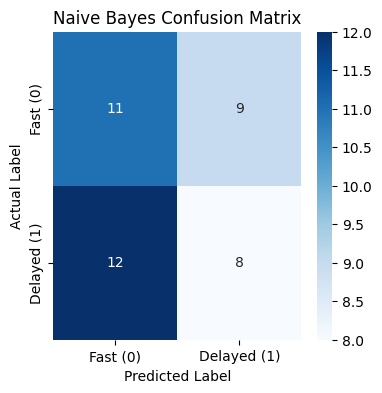

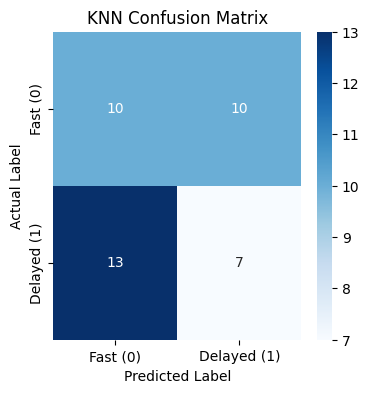

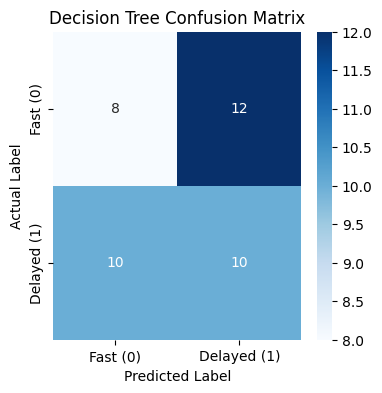

In [18]:
# Function to plot a single confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Fast (0)', 'Delayed (1)'], 
                yticklabels=['Fast (0)', 'Delayed (1)'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Generate and plot confusion matrices for all three models
plot_confusion_matrix(confusion_matrix(y_test, y_pred_gnb), 'Naive Bayes')
plot_confusion_matrix(confusion_matrix(y_test, y_pred_knn), 'KNN')
plot_confusion_matrix(confusion_matrix(y_test, y_pred_dt), 'Decision Tree')

In [19]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print("##  Generating Final Model Comparison Table")

# --- Define the function to collect metrics ---
def get_metrics(y_true, y_pred, y_proba, model_name):
    """Calculates key metrics including AUC."""
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision (Delayed)': precision_score(y_true, y_pred, pos_label=1),
        'Recall (Delayed)': recall_score(y_true, y_pred, pos_label=1),
        'F1-Score (Delayed)': f1_score(y_true, y_pred, pos_label=1),
        'ROC AUC Score': roc_auc_score(y_true, y_proba)
    }

# --- Collect all metrics ---
# NOTE: This section requires all y_pred_... and y_proba_... variables to be defined.
try:
    results = [
        get_metrics(y_test, y_pred_gnb, y_proba_gnb_delayed, 'Naive Bayes'),
        get_metrics(y_test, y_pred_knn, y_proba_knn_delayed, 'K-Nearest Neighbors'),
        get_metrics(y_test, y_pred_dt, y_proba_dt_delayed, 'Decision Tree')
    ]

    # Create and display the comparison table
    comparison_df = pd.DataFrame(results).sort_values(by='F1-Score (Delayed)', ascending=False)

    print("\nModel Performance Comparison (Optimized for Delayed Class)")
    print(comparison_df.set_index('Model').to_markdown(numalign="left", stralign="left", floatfmt=".4f"))

except NameError as e:
    print(f"\nFATAL ERROR: A variable required for the final comparison is missing: {e}")
    print("Please ensure you have run the full code blocks for Naive Bayes, KNN, and Decision Tree, including the lines that calculate 'y_proba_..._delayed'.")

##  Generating Final Model Comparison Table

Model Performance Comparison (Optimized for Delayed Class)
| Model               | Accuracy   | Precision (Delayed)   | Recall (Delayed)   | F1-Score (Delayed)   | ROC AUC Score   |
|:--------------------|:-----------|:----------------------|:-------------------|:---------------------|:----------------|
| Decision Tree       | 0.4500     | 0.4545                | 0.5000             | 0.4762               | 0.4375          |
| Naive Bayes         | 0.4750     | 0.4706                | 0.4000             | 0.4324               | 0.4275          |
| K-Nearest Neighbors | 0.4250     | 0.4118                | 0.3500             | 0.3784               | 0.4213          |
